In [1]:
# ------ MLP with BatchNorm ------

In [22]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib

Using matplotlib backend: module://matplotlib_inline.backend_inline


In [23]:
words = open('names.txt', 'r').read().splitlines()

In [24]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(itos)

In [112]:
block_size = 3

def build_dataset(words):
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xtest, Ytest = build_dataset(words[n2:])

torch.Size([182580, 3]) torch.Size([182580])
torch.Size([22767, 3]) torch.Size([22767])
torch.Size([22799, 3]) torch.Size([22799])


In [174]:
# same API as nn.Module in pytorch
class Linear:

    def __init__(self, fan_in, fan_out, bias=True):
        # random gaussian + kaiming init
        self.weight = torch.randn((fan_in, fan_out), generator=g) /fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:

    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        # calculate forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True) # batch mean
            xvar = x.var(0, keepdim=True) # batch var
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        # update buffers
        if self.training:
            # context manager, more efficient
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]


class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []

In [175]:
n_embd = 10 # embd dim
n_hidden = 100 # neurons in hidden layer
g = torch.Generator().manual_seed(2147483647)

In [176]:
C = torch.randn((vocab_size, n_embd), generator=g) # (27, 10)

In [177]:
layers = [
    Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size), 
]

In [178]:
with torch.no_grad():
    # last layer: make less confident
    layers[-1].gamma *= 0.1
    # other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 4

In [179]:
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

47024


In [180]:
# training
max_steps = 5000
batch_size = 32
lossi = []
ud = [] # update / data

for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    emb = C[Xb]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)

    # backward pass
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 50000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

    if i > 1000:
        break

      0/   5000: 3.3313


In [ ]:
# NEXT: DIAGNOSIS

layer 2 (      Tanh): mean -0.01, std 0.63, saturated: 2.91%
layer 5 (      Tanh): mean -0.01, std 0.64, saturated: 2.09%
layer 8 (      Tanh): mean -0.00, std 0.64, saturated: 2.47%
layer 11 (      Tanh): mean -0.00, std 0.64, saturated: 2.25%
layer 14 (      Tanh): mean +0.00, std 0.64, saturated: 2.38%


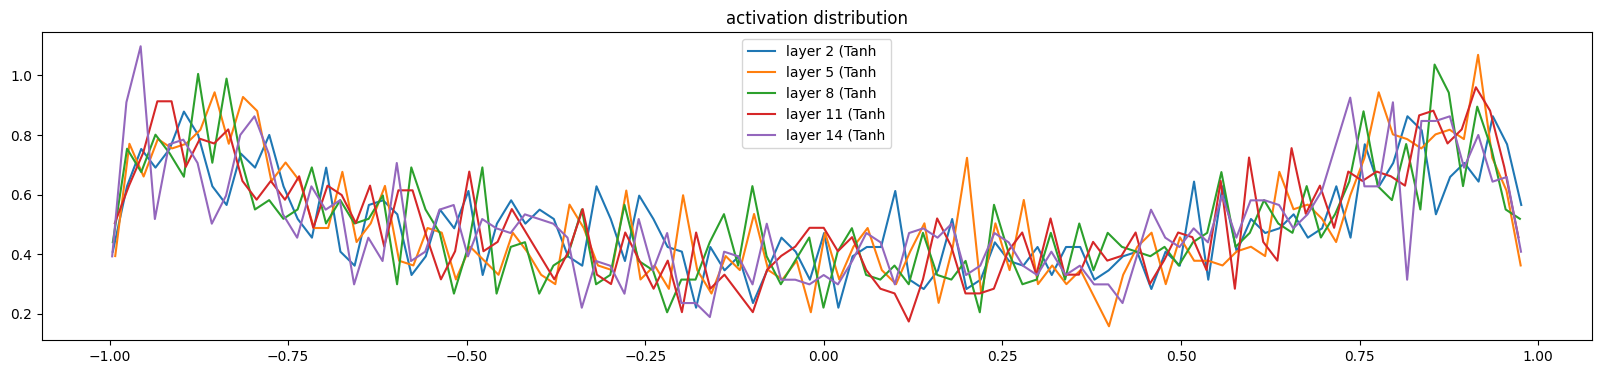

In [189]:
# visualize histograms
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution');
# we want low saturation, say 5%, and a similar plot for each layer
# forward pass activations

layer 2 (      Tanh): mean +0.000000, std 3.497827e-03
layer 5 (      Tanh): mean -0.000000, std 3.067326e-03
layer 8 (      Tanh): mean +0.000000, std 2.866081e-03
layer 11 (      Tanh): mean +0.000000, std 2.681179e-03
layer 14 (      Tanh): mean +0.000000, std 2.554174e-03


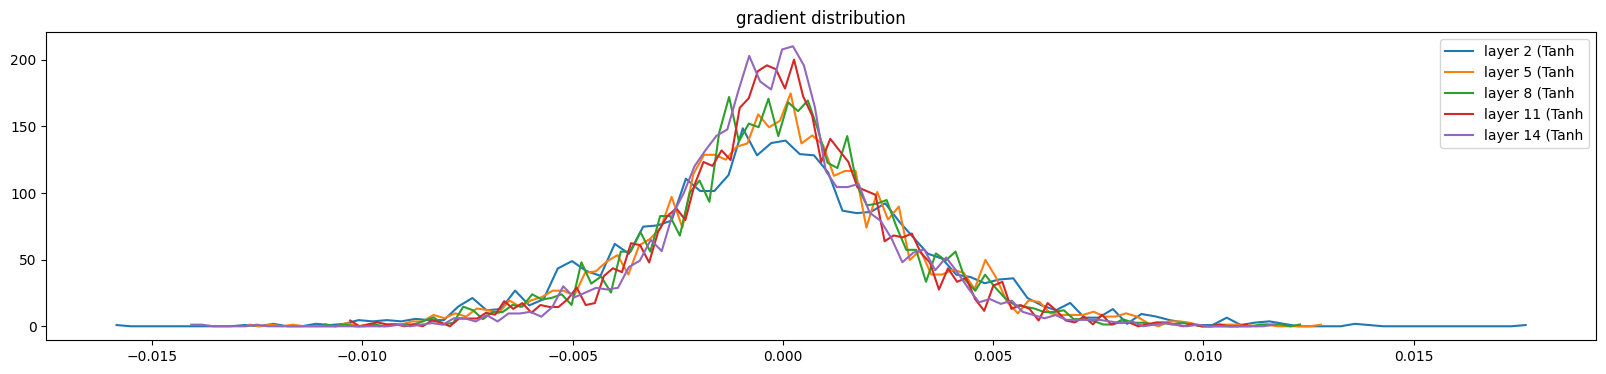

In [190]:
# visualize histograms
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution');
# we want gradient distro to be similar (normalized) between layers
# backward pass gradients

weight   (27, 10) | mean +0.000000 | std 7.799974e-03 | grad:data ratio 7.792344e-03
weight  (30, 100) | mean +0.000094 | std 3.269874e-03 | grad:data ratio 4.368496e-03
weight (100, 100) | mean -0.000026 | std 3.003454e-03 | grad:data ratio 7.531636e-03
weight (100, 100) | mean -0.000017 | std 2.809443e-03 | grad:data ratio 6.971547e-03
weight (100, 100) | mean +0.000029 | std 2.476584e-03 | grad:data ratio 6.171501e-03
weight (100, 100) | mean -0.000015 | std 2.354074e-03 | grad:data ratio 5.860711e-03
weight  (100, 27) | mean +0.000003 | std 3.957010e-03 | grad:data ratio 1.000207e-02


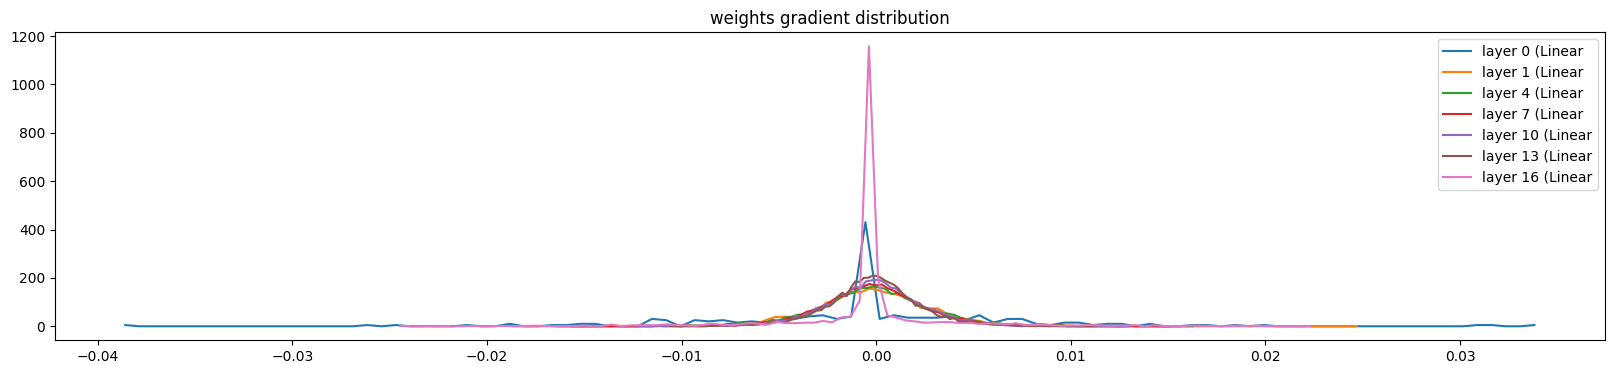

In [192]:
# visualize histograms
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2:
        print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('weights gradient distribution');
# visualizing weights' properties by layer

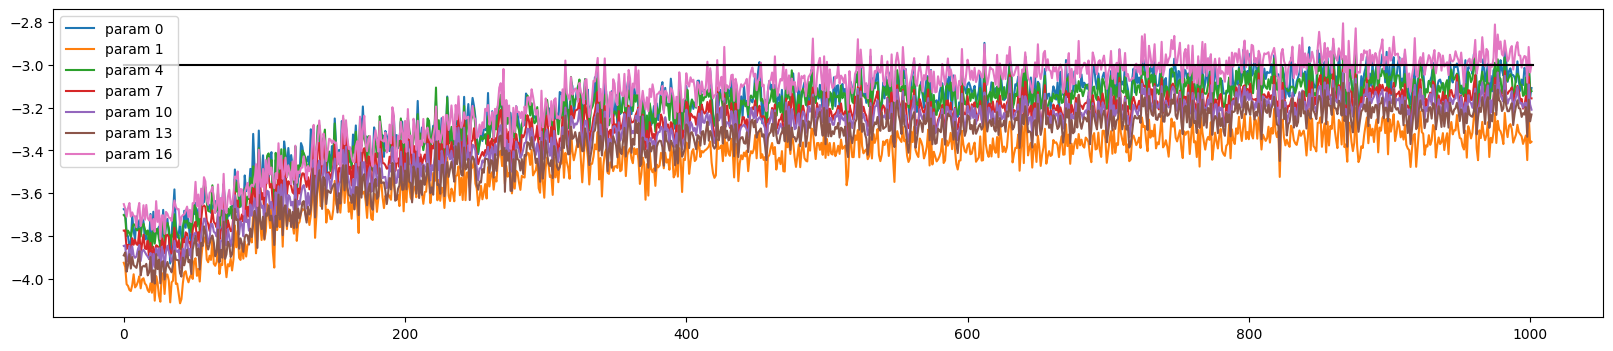

In [193]:
# play with a very low learning rate, check results
# charting update/data for each iteration for each param
# with a very low learning rate, update/data stabilize at < 1e-3 (i.e. 1e-5)
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);